![Inicio](doc/inicio.png)

## **Trabajo Final**

## Yoga Pose Estimation 

## Autor: Juan Ignacio Ribet

### Director:  Juan Pablo Pizarro (Globant)

### Programa de vinculacion con empresa Globant

Resumen

La presente memoria describe el desarrollo de un detector de postura de yoga o
asanas para la empresa Globant. Este trabajo pretende obtener el mínimo
producto viable de una aplicación para entrenamiento de yoga, en donde se
detecte la postura mediante algoritmos de aprendizaje de máquina y visión por
computadora, y se le de soporte al usuario para realizarlas de forma correcta.

Para su desarrollo fueron fundamentales los conocimientos adquiridos en la
carrera, en especial los vistos en las materias de visión por computadora con el
uso indispensable de la librería OpenCV como también los conceptos de
aprendizaje de máquina, análisis de datos y la comprensión del mecanismo de
funcionamiento de las de las redes neuronales convolucionales.

## Tabla de contenido
----

1.	Planteo del problema<br>
2.	Visualización de los datos<br>
3.	Creación del dataset para entrenar<br>
3.1.	Generación de cada dataset<br>
4.	Carga de los datasets generados<br>
5.	Verificación del balance de clases<br>
6.	Entrenamiento de los modelos<br>
7.	Verificación de modelo con imágenes de validación<br>
8.	Matriz de confusión en set de prueba<br>
9.	Optuna: Optimización de hiperparametros<br>
10.	Estimación de posturas en video<br>
11.	Interfaz<br>



# Planteo del problema

Este trabajo tiene un objetivo primario: el desarrollo de un prototipo de aplicación, que cuente con la función de detectar las posturas de yoga, utilizando las herramientas disponibles en visión por computadora, aprendizaje de maquina y análisis de datos. El sistema deberá poder ser utilizado en dispositivos de bajos recursos computacionales, que a su vez dispongan de cámara web para la obtención de los videos. Estas dos condiciones son necesarias pues la detección tiene que ser realizada en tiempo real. Complementando la detección el modelo buscará mostrar referencias visuales al usuario que lo ayuden a lograr la postura correctamente.

Este prototipo implica tambien el desarrollo de una interfaz simple y funcional.

In [10]:
# Import the necessary libraries
import random
import os
import platform
import sys
import cv2
import csv
import pathlib
import time
import pickle
import optuna
import math
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import iglob


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import svm

import mediapipe as mp

### Descarga del Dataset

### Download Dataset

In [27]:
# Unzip and download dataset

if os.access('./DATASET', os.F_OK) is False:
    if os.access('DATASET.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://github.com/Juaniribet/Vision_Computadora_II_CEIA/main/DATASET.zip -o DATASET.zip
        else:
            !wget DATASET.zip https://github.com/Juaniribet/Vision_Computadora_II_CEIA/raw/main/DATASET.zip
    import zipfile
    with zipfile.ZipFile('DATASET.zip','r') as zip_ref:
        zip_ref.extractall()
else:
    print("El dataset ya se encuentra descargado")

### Visualización de los datos

Definición de variables y visualización de cada clase

### Data vizualization

Definition of variables and visualization of each class

In [28]:
if 'google.colab' in sys.modules:
  train_folder = '/content/DATASET/TRAIN'
  test_folder = '/content/DATASET/TEST'
  valid_folder = '/content/DATASET/VALID'
  dataset_folder = '/content/DATASET'
else:
  train_folder = 'DATASET/TRAIN'
  test_folder = 'DATASET/TEST'
  valid_folder = 'DATASET/VALID'
  dataset_folder = 'DATASET'

CLASES = []
for class_name in os.listdir(train_folder):
  CLASES.append(class_name)

CANTIDAD_CLASES = len(CLASES)

print(f'CLASSES: {CLASES}')
print(f'CLASSES_QUANTITY: {CANTIDAD_CLASES}')

CLASSES: ['downdog', 'goddess', 'tree', 'warrior']
CLASSES_QUANTITY: 4


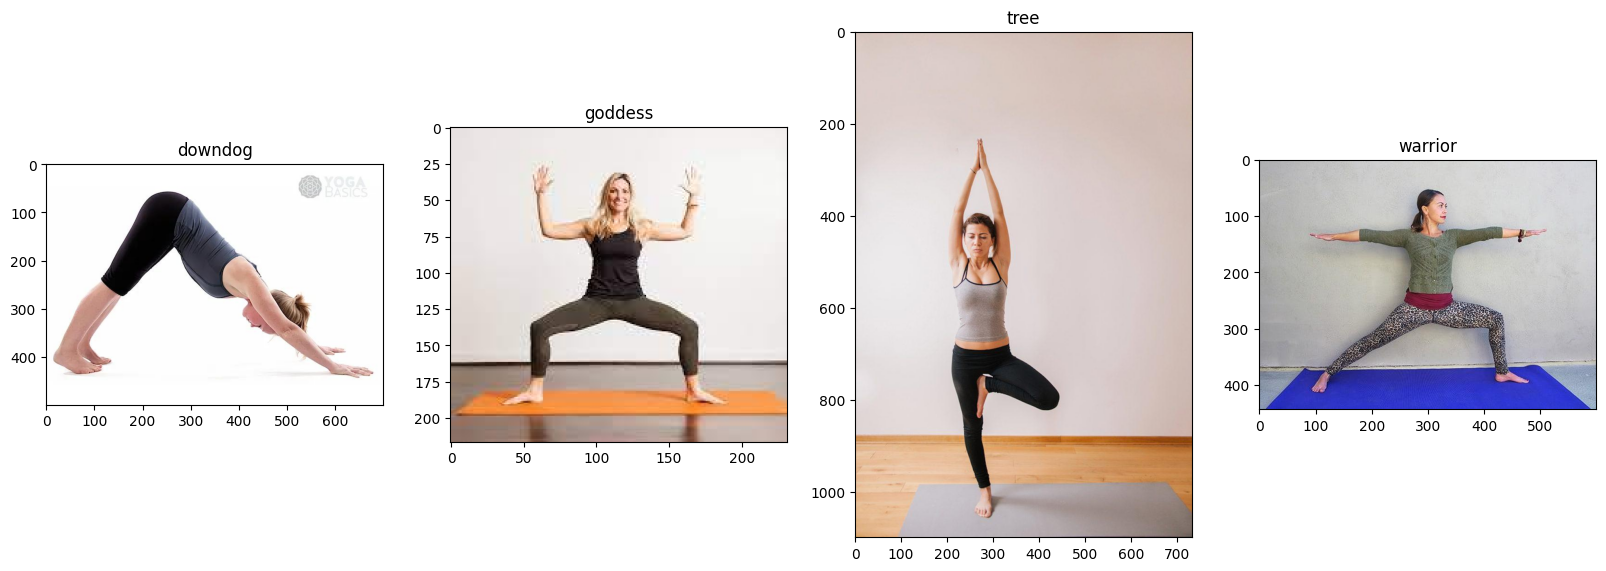

In [29]:
fig, axs = plt.subplots(1, CANTIDAD_CLASES, figsize=(20, 20))

for id, class_folder in enumerate(sorted(os.listdir(train_folder))):

    image_name = random.choice(os.listdir(os.path.join(train_folder, class_folder)))
    image = mpimg.imread(os.path.join(train_folder, class_folder, image_name))

    axs[id].imshow(image)
    axs[id].set_title(class_folder)

# Creación del dataset para entrenar

GetCoordsLandmarksImages: clase para generar los dataset de coordenadas de los puntos claves del modelo de MediaPipe desde las imagenes

## Creation of the dataset to train

GetCoordsLandmarksImages: class to generate the coordinate dataset of the key points of the MediaPipe model from the images

In [22]:
class GetCoordsLandmarksImages():

    '''class to obtain the coordinates of the landmarks form body images  using MediaPipe-Pose
    framework'''

    def __init__(self):

        self.file_list_used= []
        self.mp_pose = mp.solutions.pose # Mediapipe Solutions
        pass

    def create_csv_file(self, file_name: str):

        '''"file_name": The name of the csv file as it will be stored. ("file_name.csv").'''

        self.file_name = file_name + '.csv'

        landmarks = ['class', 'path']
        for val in range(0, 33):
            landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

        with open(file_name + '.csv', mode='w', newline='') as f:
            csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(landmarks)


    def get_coord(self, rootdir: str, class_name = None, file_name = None):

        '''
        Create a dataset with the coord of the landmarks of the images or videos stored in "rootdir"

        "rootdir": Path of the folder where the images or videos are stored.

        "class_name" : str, default = None - If not given, will be the folder name where the images
        or video are stored.

        "file_name" : str, default = None - If not given, the file created in "create_csv_file()"
        will be used.

        "min_detection_confidence" : mp_pose min_detection_confidence (default = 0.6).

        "min_tracking_confidence": mp_pose min_detection_confidence (default = 0.6).

        '''

        self.rootdir_glob = rootdir

        if file_name == None:
            file_name = self.file_name

        path_files_list = [f for f in iglob(rootdir, recursive=True) if os.path.isfile(f)]

        for path in path_files_list:

            image = cv2.imread(path)

            if class_name == None:
                class_name = pathlib.PurePath(os.path.normpath(path))
                class_name = class_name.parent.name


            with self.mp_pose.Pose(static_image_mode=True,
                                    min_detection_confidence=0.5) as pose:

                try:
                    # Recolor Feed
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image.flags.writeable = False

                    # Make Detections
                    results = pose.process(image)

                    # Recolor image back to BGR for rendering
                    image.flags.writeable = True
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                # Export coordinates

                    # Extract Pose landmarks
                    poses = results.pose_landmarks.landmark
                    pose_row = list(np.array(
                        [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                         for landmark in poses]).flatten())

                    # Append class name
                    pose_row.insert(0, class_name)
                    pose_row.insert(1, path)
                    self.file_list_used.append(path)

                    # Export to CSV
                    with open(file_name, mode='a', newline='') as f:
                        csv_writer = csv.writer(f, delimiter=',', quotechar='"',
                                                quoting=csv.QUOTE_MINIMAL)
                        csv_writer.writerow(pose_row)

                except:
                    pass

    def bad_images(self):

        '''Return the images that are bad for detection'''

        path_files_list = [f for f in iglob(self.rootdir_glob, recursive=True)
                           if os.path.isfile(f)]


        images_not_used=[]
        for j in path_files_list:
            if j not in self.file_list_used:
                images_not_used.append(j)

        print(f'{len(images_not_used)} bad images of {len(path_files_list)}')

        if len(images_not_used) > 0:
            print(images_not_used)

### Generación de cada Dataset

### Generation of each Dataset

In [23]:
get_data = GetCoordsLandmarksImages()
get_data.create_csv_file('coord_dataset_csv/df_downdog_train')
get_data.get_coord(train_folder + '/downdog/*', class_name='downdog')
get_data.bad_images()

0 bad images of 228


In [24]:
get_data.create_csv_file('coord_dataset_csv/df_downdog_test')
get_data.get_coord(test_folder +'/downdog/*', class_name='downdog')
get_data.bad_images()

0 bad images of 57


In [25]:
get_data.create_csv_file('coord_dataset_csv/df_goddess_train')
get_data.get_coord(train_folder +'/goddess/*', class_name='goddess')
get_data.bad_images()

0 bad images of 213


In [26]:
get_data.create_csv_file('coord_dataset_csv/df_goddess_test')
get_data.get_coord(test_folder +'/goddess/*', class_name='goddess')
get_data.bad_images()

0 bad images of 54


In [27]:
get_data.create_csv_file('coord_dataset_csv/df_tree_train')
get_data.get_coord(train_folder +'/tree/*', class_name='tree')
get_data.bad_images()

0 bad images of 222


In [28]:
get_data.create_csv_file('coord_dataset_csv/df_tree_test')
get_data.get_coord(test_folder +'/tree/*', class_name='tree')
get_data.bad_images()

0 bad images of 56


In [29]:
get_data.create_csv_file('coord_dataset_csv/df_warrior_train')
get_data.get_coord(train_folder +'/warrior/*', class_name='warrior')
get_data.bad_images()

0 bad images of 217


In [30]:
get_data.create_csv_file('coord_dataset_csv/df_warrior_test')
get_data.get_coord(test_folder +'/warrior/*', class_name='warrior')
get_data.bad_images()

0 bad images of 55


### Carga de los datasets generados

#### Loading the generated datasets

In [133]:
df_downdog_train = pd.read_csv("coord_dataset_csv/df_downdog_train.csv")
df_downdog_test = pd.read_csv("coord_dataset_csv/df_downdog_test.csv")
df_goddess_train = pd.read_csv("coord_dataset_csv/df_goddess_train.csv")
df_goddess_test = pd.read_csv("coord_dataset_csv/df_goddess_test.csv")
df_tree_train = pd.read_csv("coord_dataset_csv/df_tree_train.csv")
df_tree_test = pd.read_csv("coord_dataset_csv/df_tree_test.csv")
df_warrior_train = pd.read_csv("coord_dataset_csv/df_warrior_train.csv")
df_warrior_test = pd.read_csv("coord_dataset_csv/df_warrior_test.csv")

Armado el dataset de entrenamiento

Assembled the training dataset

In [134]:
df_yoga_train = pd.concat([df_downdog_train, df_goddess_train,df_tree_train,df_warrior_train],
                          ignore_index=True)
# df_yoga_train['class'] = df_yoga_train['class'].replace(name_to_idx)
df_yoga_train

class                             path        x0        y0        z0  \
0    downdog  DATASET/TRAIN/downdog\00000.jpg  0.511189  0.727550 -0.076373   
1    downdog  DATASET/TRAIN/downdog\00001.jpg  0.568022  0.786379 -0.044425   
2    downdog  DATASET/TRAIN/downdog\00002.jpg  0.608902  0.736586 -0.031492   
3    downdog  DATASET/TRAIN/downdog\00003.jpg  0.541984  0.758109 -0.096469   
4    downdog  DATASET/TRAIN/downdog\00004.jpg  0.360903  0.700388 -0.033786   
..       ...                              ...       ...       ...       ...   
875  warrior  DATASET/TRAIN/warrior\00212.jpg  0.499194  0.384605 -0.111064   
876  warrior  DATASET/TRAIN/warrior\00213.jpg  0.584924  0.397947 -0.278694   
877  warrior  DATASET/TRAIN/warrior\00214.jpg  0.447357  0.221157 -0.378068   
878  warrior  DATASET/TRAIN/warrior\00215.jpg  0.518319  0.188786 -0.313877   
879  warrior  DATASET/TRAIN/warrior\00216.jpg  0.482947  0.204508 -0.106461   

           v0        x1        y1        z1        v1  ...       z30  \
0    0.999087  0.494254  0.750801 -0.115903  0.999525  ...  0.349741   
1    0.999655  0.581655  0.794644 -0.024105  0.999690  ... -0.142834   
2    0.999770  0.629058  0.740810 -0.005169  0.999771  ... -0.146727   
3    0.999904  0.561617  0.768991 -0.074017  0.999896  ... -0.031129   
4    0.997857  0.340383  0.711678 -0.076438  0.998727  ...  0.364820   
..        ...       ...       ...       ...       ...  ...       ...   
875  0.999579  0.504037  0.371839 -0.114633  0.997423  ...  0.080119   
876  0.999918  0.581858  0.384461 -0.237754  0.999785  ... -0.003061   
877  0.999972  0.455515  0.199518 -0.348565  0.999860  ...  0.063277   
878  0.999998  0.527133  0.170191 -0.279705  0.999996  ... -0.141693   
879  0.999823  0.490771  0.186224 -0.112046  0.999126  ...  0.030736   

          v30       x31       y31       z31       v31       x32       y32  \
0    0.572870  0.789083  0.920681 -0.254881  0.981300  0.775926  0.902560   
1    0.996496  0.248387  0.902885  0.072101  0.638526  0.238052  0.910098   
2    0.996390  0.212486  0.909015  0.215780  0.676139  0.201758  0.923530   
3    0.997919  0.276310  0.879952  0.286139  0.832718  0.262517  0.886805   
4    0.468797  0.745153  0.924358 -0.274635  0.975121  0.724463  0.912739   
..        ...       ...       ...       ...       ...       ...       ...   
875  0.996445  0.665906  0.831001 -0.126886  0.996586  0.388216  0.831052   
876  0.971639  0.776543  0.972285 -0.023407  0.989177  0.259307  0.982626   
877  0.988696  0.723612  0.927647 -0.309367  0.990107  0.138938  0.899099   
878  0.984783  0.714631  0.929704  0.347830  0.982268  0.324148  0.981388   
879  0.990055  0.717312  0.955993 -0.156758  0.985759  0.308552  0.927293   

          z32       v32  
0    0.247644  0.584526  
1   -0.274867  0.992569  
2   -0.320097  0.993469  
3   -0.191682  0.996327  
4    0.272612  0.477174  
..        ...       ...  
875  0.026301  0.992905  
876 -0.165598  0.995593  
877 -0.060792  0.985239  
878 -0.300075  0.997440  
879 -0.041138  0.982668  

[880 rows x 134 columns]

Armado el dataset de test

Assembled the test dataset

In [135]:
df_yoga_test = pd.concat([df_downdog_test, df_goddess_test,df_tree_test,df_warrior_test],
                         ignore_index=True)
# df_yoga_test['class'] = df_yoga_test['class'].replace(name_to_idx)
df_yoga_test

class                            path        x0        y0        z0  \
0    downdog  DATASET/TEST/downdog\00228.jpg  0.603251  0.714973 -0.026274   
1    downdog  DATASET/TEST/downdog\00229.jpg  0.577452  0.779198 -0.071213   
2    downdog  DATASET/TEST/downdog\00230.jpg  0.328606  0.771511 -0.063471   
3    downdog  DATASET/TEST/downdog\00231.jpg  0.542061  0.648875 -0.012753   
4    downdog  DATASET/TEST/downdog\00232.jpg  0.530507  0.742806  0.002176   
..       ...                             ...       ...       ...       ...   
217  warrior  DATASET/TEST/warrior\00267.jpg  0.484089  0.203997 -0.111081   
218  warrior  DATASET/TEST/warrior\00268.jpg  0.432160  0.198838 -0.387388   
219  warrior  DATASET/TEST/warrior\00269.jpg  0.421851  0.333012 -0.195190   
220  warrior  DATASET/TEST/warrior\00270.jpg  0.541960  0.253691 -0.311029   
221  warrior  DATASET/TEST/warrior\00271.jpg  0.464490  0.128971 -0.120755   

           v0        x1        y1        z1        v1  ...       z30  \
0    0.999967  0.619374  0.720470 -0.013955  0.999962  ...  0.048538   
1    0.999935  0.597411  0.784217 -0.048661  0.999945  ... -0.133076   
2    0.995163  0.307143  0.767711 -0.104149  0.996052  ...  0.326164   
3    0.999859  0.552049  0.658177 -0.000413  0.999824  ... -0.067906   
4    0.999984  0.548443  0.760892  0.022248  0.999980  ...  0.118062   
..        ...       ...       ...       ...       ...  ...       ...   
217  0.999938  0.491651  0.187007 -0.113273  0.999716  ...  0.027554   
218  0.999968  0.444920  0.180878 -0.382607  0.999780  ... -0.089547   
219  0.999943  0.426797  0.317650 -0.201206  0.999601  ...  0.083238   
220  0.999986  0.536933  0.238940 -0.286740  0.999945  ...  0.058292   
221  0.999994  0.476415  0.108416 -0.128763  0.999979  ... -0.042618   

          v30       x31       y31       z31       v31       x32       y32  \
0    0.996935  0.322599  0.879771  0.232244  0.893264  0.307449  0.904003   
1    0.989042  0.300147  0.862950  0.131157  0.526981  0.291627  0.873573   
2    0.524521  0.759748  0.902575 -0.291439  0.980245  0.749885  0.896683   
3    0.999538  0.377171  0.803991  0.091059  0.910834  0.372542  0.821747   
4    0.997261  0.239970  0.891590  0.304190  0.901485  0.220226  0.919155   
..        ...       ...       ...       ...       ...       ...       ...   
217  0.988865  0.714938  0.962638 -0.165509  0.989565  0.314849  0.930008   
218  0.991252  0.825170  0.791324  0.084845  0.978573  0.180136  0.781066   
219  0.995784  0.654345  0.939613 -0.251115  0.997821  0.275559  0.888648   
220  0.959162  0.698355  0.890077 -0.131697  0.993748  0.299599  0.913692   
221  0.991180  0.760931  0.926515 -0.194955  0.993155  0.229075  0.900245   

          z32       v32  
0   -0.050057  0.996111  
1   -0.275342  0.979802  
2    0.219774  0.497387  
3   -0.153075  0.999040  
4    0.005179  0.996371  
..        ...       ...  
217 -0.046122  0.984864  
218 -0.247969  0.989746  
219  0.037844  0.990626  
220 -0.088099  0.993308  
221 -0.155714  0.992226  

[222 rows x 134 columns]

División de los datsets

Division of the datasets

In [136]:
X_train = df_yoga_train.drop(columns=['class', 'path'])
y_train = df_yoga_train['class']
X_test = df_yoga_test.drop(columns=['class', 'path'])
y_test = df_yoga_test['class']

In [137]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

test_slip = int((X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]))*100)
train_slip = int((X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]))*100)


print(f'Split Train/Test: {int(train_slip)}%-{int(test_slip)}%')

X_train shape:  (880, 132)
X_test shape:  (222, 132)
y_train shape:  (880,)
y_test shape:  (222,)
Split Train/Test: 79%-20%


### Verificación del balance de clases

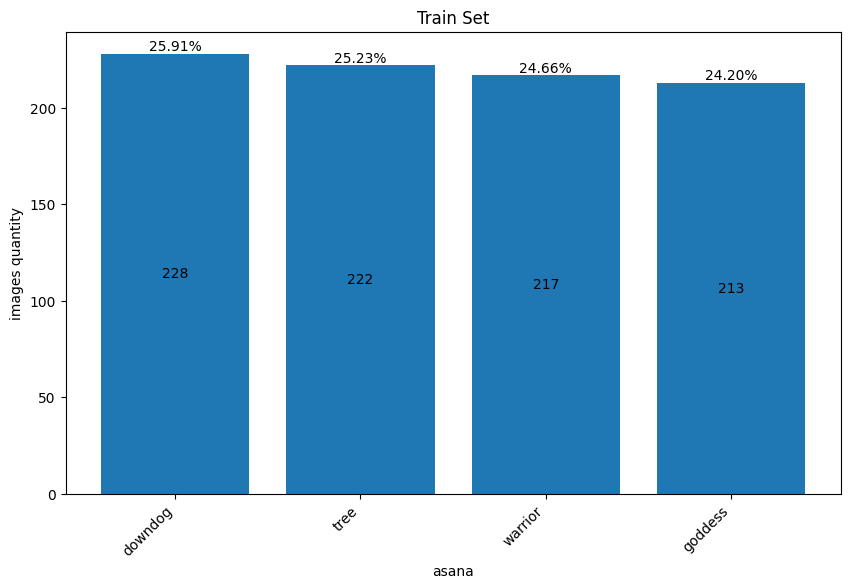

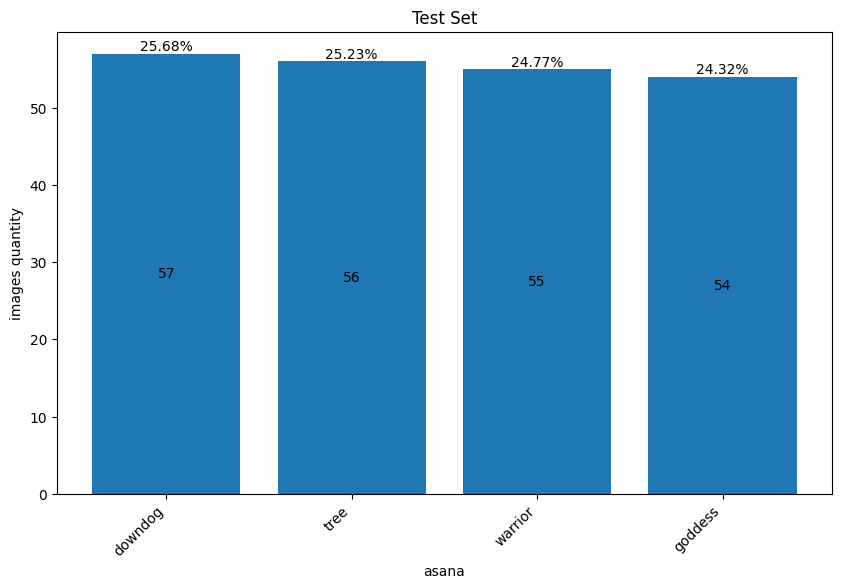

In [138]:
# Calcular counts y porcentajes
for i, set in zip((y_train, y_test), ('Train Set', 'Test Set')):
    valid_categories = i
    category_counts = valid_categories.value_counts()
    total_count = len(valid_categories)
    category_percentages = (category_counts / total_count) * 100

    # Grafico
    plt.figure(figsize=(10, 6))
    bars = plt.bar(category_counts.index, category_counts)
    #bars = plt.bar(name_to_idx.keys, category_counts)
    plt.xlabel("asana")
    plt.ylabel("images quantity")
    plt.bar_label(bars, label_type='center')

    # Agregar porcentajes sobre las barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        category = category_counts.index[i]
        if category in category_percentages:
            percentage = category_percentages[category]
            plt.text(bar.get_x() + bar.get_width() / 2,
                     height,
                     f"{percentage:.2f}%",
                     ha="center",
                     va="bottom")
    
    plt.xticks(rotation=45, ha="right")
    plt.title(str(set))
    plt.show()

# Entrenamiento de los modelos

## Model training

In [139]:
# Definicion de los modelos a entrenar
pipelines = {
    'lr':make_pipeline(LogisticRegression(max_iter = 2000)),
    'lrcv': make_pipeline(LogisticRegressionCV(max_iter = 2000)),
    'rf':make_pipeline(RandomForestClassifier()),
    'svm':make_pipeline(svm.SVC()),
    'AdaBC':make_pipeline(AdaBoostClassifier()),
    'bagg':make_pipeline(BaggingClassifier()),
}

# Entrenamiento de los modelos
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

# Evaluación de los modelos
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(f'Accuracy {algo}: {accuracy_score(y_test, yhat):.5%}')

model = fit_models['lrcv']

Accuracy lr: 99.09910%
Accuracy lrcv: 99.54955%
Accuracy rf: 99.54955%
Accuracy svm: 99.54955%
Accuracy AdaBC: 45.49550%
Accuracy bagg: 98.19820%


Por los valores de accuracy se selecciona el modelo Logistic Regression CV

Due to the accuracy values, the Logistic Regression CV model is selected

In [10]:
# Save model
import pickle
with open('interface\pages\Data\models\yoga_pose_detection_model.pkl', 'wb') as f:
    pickle.dump(fit_models['lrcv'], f)

In [4]:
# Load model
with open('interface\pages\Data\models\yoga_pose_detection_model.pkl', 'rb') as f:
    model = pickle.load(f)

## Verificación de modelo con imagenes de validación

In [5]:
mp_pose = mp.solutions.pose # Mediapipe Solutions

landmarks = []
for val in range(0, 33):
            landmarks += ['x{}'.format(val),
                          'y{}'.format(val),
                          'z{}'.format(val),
                          'v{}'.format(val)]

### Verificación con las imágenes de validación

#### Verification with validation images

File name: downdog.jpg - Predicction: downdog


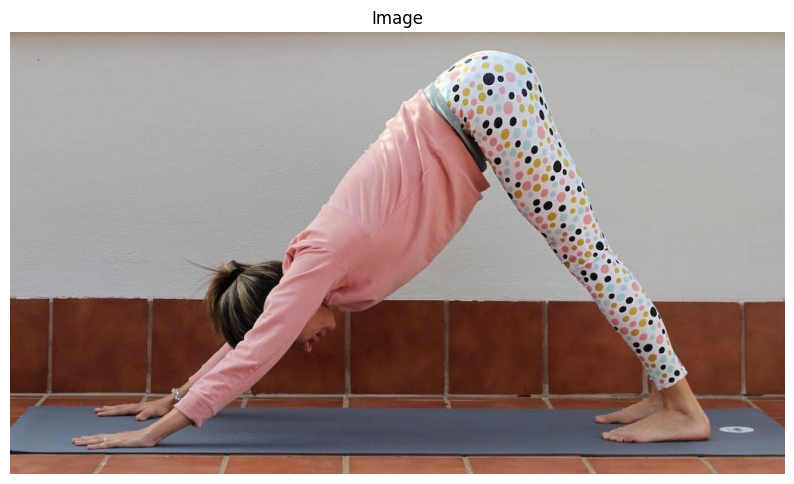

File name: goddess.jpg - Predicction: goddess


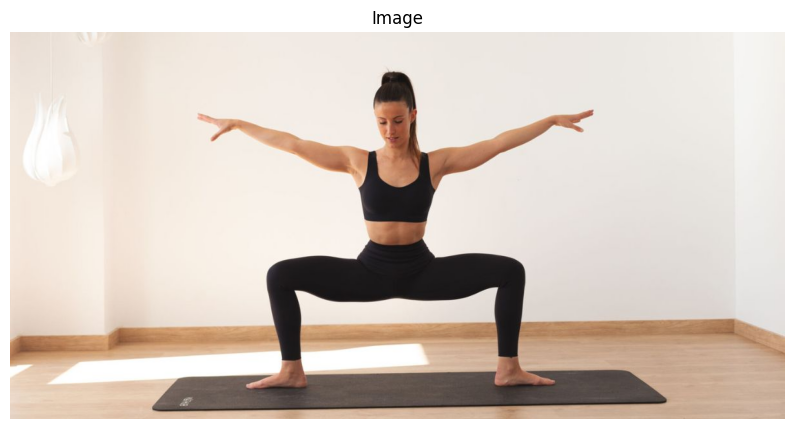

File name: tree.jpg - Predicction: tree


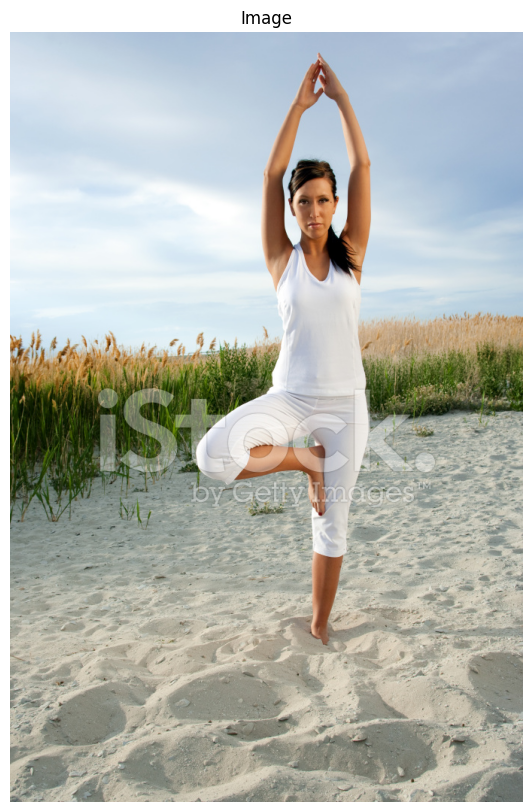

File name: warrior.jpg - Predicction: warrior


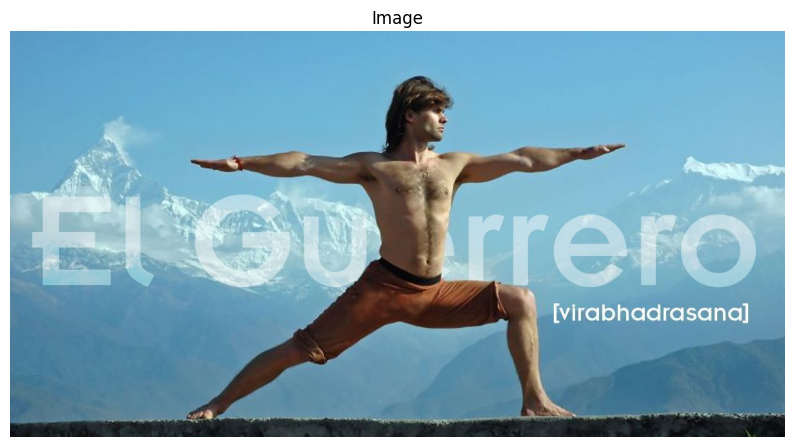

In [6]:
path = valid_folder

for img in os.listdir(path):

    image_path = path + '/' + img

    image = cv2.imread(image_path)

    with mp_pose.Pose(
        static_image_mode=True,
        min_detection_confidence=0.5) as pose:

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = pose.process(image)

        #Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        poses = results.pose_landmarks.landmark
        pose_row = list(np.array(
            [[landmark.x, landmark.y, landmark.z, landmark.visibility]
            for landmark in poses]).flatten())

        X = pd.DataFrame([pose_row], columns=landmarks)
        body_language_class = model.predict(X)[0]
        #body_language_class = idx_to_name[model.predict(X)[0]]

        print(f'File name: {img} - Predicction: {body_language_class}')
        plt.figure(figsize=[10,10])
        plt.title('Image'); plt.axis('off');plt.imshow(image[:,:,::-1]);plt.show()

## Matriz de confusión en set de prueba

### Confusion matrix in test set

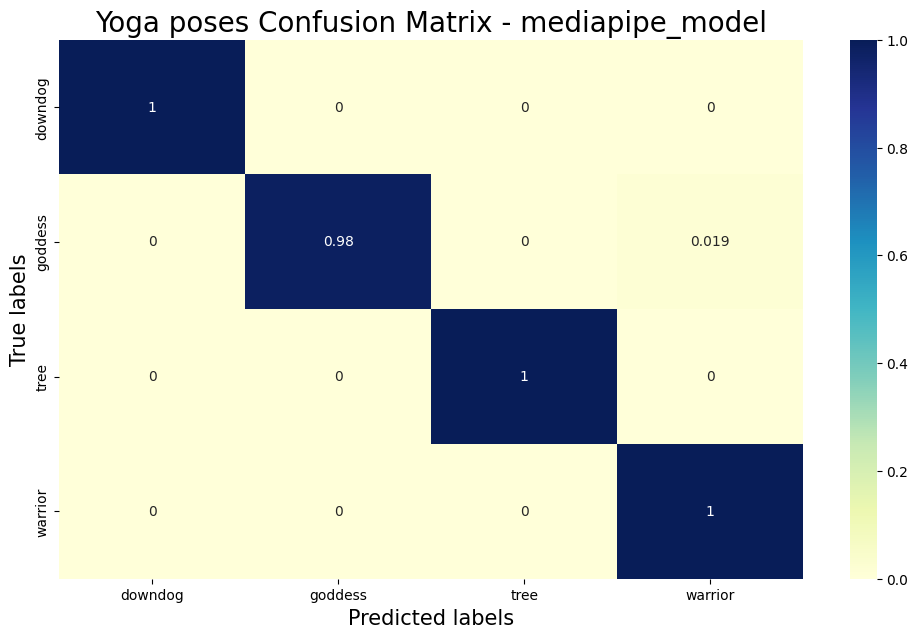

Accuracy : 99.55%


In [146]:
y_mediapipe = []
y_hat_mediapipe = []
file_name = []

path = test_folder
for class_name in os.listdir(path):
    for image in os.listdir(path + '/' +  class_name):

        image_path = path + '/' + class_name + '/' + image

        image = cv2.imread(image_path)

        with mp_pose.Pose(static_image_mode=True,
                          min_detection_confidence=0.5) as pose:

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make Detections
            results = pose.process(image)

            #Recolor image back to BGR for rendering
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            poses = results.pose_landmarks.landmark
            pose_row = list(np.array(
                [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                for landmark in poses]).flatten())

            X = pd.DataFrame([pose_row], columns=landmarks)
            body_language_class = model.predict(X)[0]
            #body_language_class = idx_to_name[model.predict(X)[0]]

        y_mediapipe.append(class_name)
        y_hat_mediapipe.append(body_language_class)
        file_name.append(image_path)

cf_matrix = confusion_matrix(y_mediapipe, y_hat_mediapipe)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in list(df_yoga_train['class'].unique())],
                     columns = [i for i in list(df_yoga_train['class'].unique())])

#df_cm.rename(columns = idx_to_name, index=idx_to_name, inplace = True)

plt.figure(figsize = (12,7))
ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.title('Yoga poses Confusion Matrix - mediapipe_model', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)
plt.show()

print(f'Accuracy : {accuracy_score(y_mediapipe, y_hat_mediapipe):.2%}')

In [143]:
data = pd.DataFrame(list(zip(file_name, y_mediapipe, y_hat_mediapipe)),
                    columns = ['file_name', 'class', 'y_hat_mediapipe'])
data.head()

file_name    class y_hat_mediapipe
0  DATASET/TEST/downdog/00228.jpg  downdog         downdog
1  DATASET/TEST/downdog/00229.jpg  downdog         downdog
2  DATASET/TEST/downdog/00230.jpg  downdog         downdog
3  DATASET/TEST/downdog/00231.jpg  downdog         downdog
4  DATASET/TEST/downdog/00232.jpg  downdog         downdog

62, class: goddess , predicción: warrior


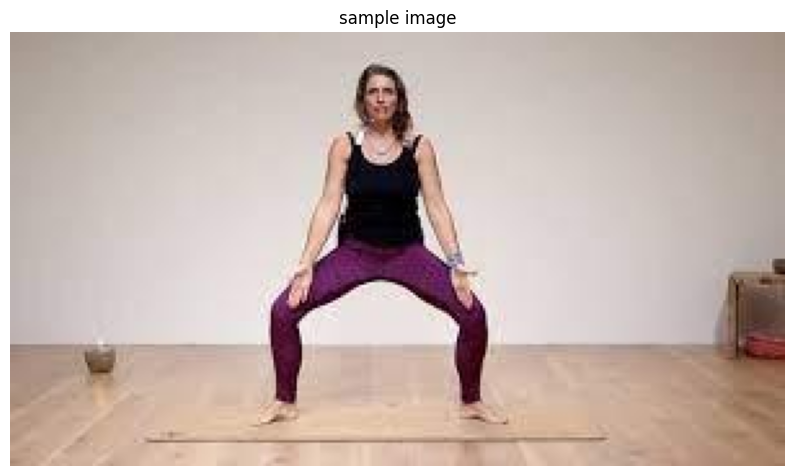

In [147]:
# Display the image that the model detected incorrectly
n=-1
for i, j in zip(data['class'], data['y_hat_mediapipe']):
  n += 1
  if i != j:
    print(f'{n}, class: {i} , predicción: {j}')
    sample_img = cv2.imread(data['file_name'][n])
    plt.figure(figsize=[10,10])
    plt.title('sample image'); plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

## Optuna: Optimización de hiperparametros

Si bien el accuracy del modelo es muy alto se verifica con Optuna si se puede mejorar

Although the model's accuracy is very high, it is verified with Optuna if it can be improved

In [145]:
# Define the objective function for hyperparameter optimization
def objective(trial):
    """
    Objective function for optimizing hyperparameters of a RandomForestClassifier using Optuna.
    
    Args:
        trial: A `Trial` object from Optuna that contains the state of the optimization trial.
    
    Returns:
        The accuracy score of the RandomForestClassifier using the hyperparameters suggested by Optuna.
    """
    # Define the hyperparameters to optimize
    max_iter = trial.suggest_int('max_iter', 100, 2000)
    penalty = trial.suggest_categorical("penalty", ['l1', 'l2'])
    tol = trial.suggest_float('tol', 1e-4, 1e-3)
    C  = trial.suggest_float("C", 0.5, 1)

    if penalty == 'l1':
        solver = trial.suggest_categorical("solver1", ['liblinear'])
    if penalty == 'l2':
        solver = trial.suggest_categorical("solver2", ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
        
    
    # Crear el clasificador con los hiperparámetros sugeridos por Optuna
    clf = LogisticRegression(
                                    max_iter=max_iter,
                                    penalty=penalty,
                                    tol=tol,
                                    C=C,
                                    solver=solver
                                    )
    
    # Entrenar el clasificador y calcular la precisión en el conjunto de prueba
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return score

# Create the Optuna study and run the optimization

#sampler = optuna.samplers.RandomSampler(seed=42)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

# Print optimization results
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2023-10-18 09:48:20,886] A new study created in memory with name: no-name-017b9fbf-756e-484f-9783-09bed0fd6739
[I 2023-10-18 09:48:20,984] Trial 0 finished with value: 0.9864864864864865 and parameters: {'max_iter': 812, 'penalty': 'l1', 'tol': 0.000638792635777333, 'C': 0.5780093202212182, 'solver1': 'liblinear'}. Best is trial 0 with value: 0.9864864864864865.
[I 2023-10-18 09:48:21,052] Trial 1 finished with value: 0.990990990990991 and parameters: {'max_iter': 396, 'penalty': 'l2', 'tol': 0.000641003510568888, 'C': 0.8540362888980227, 'solver2': 'liblinear'}. Best is trial 1 with value: 0.990990990990991.
[I 2023-10-18 09:48:21,208] Trial 2 finished with value: 0.9954954954954955 and parameters: {'max_iter': 678, 'penalty': 'l1', 'tol': 0.0003621062261782377, 'C': 0.8059264473611898, 'solver1': 'liblinear'}. Best is trial 2 with value: 0.9954954954954955.
[I 2023-10-18 09:48:21,346] Trial 3 finished with value: 0.990990990990991 and parameters: {'max_iter': 365, 'penalty': 'l2',

Best trial: score 0.9954954954954955, params {'max_iter': 678, 'penalty': 'l1', 'tol': 0.0003621062261782377, 'C': 0.8059264473611898, 'solver1': 'liblinear'}


Se ve que el valor de accuracy que se obtuvo con los valores default de regresión logistica y 'max_iter'= 2000 es la mejor


It is seen that the accuracy value obtained with the default values of logistic regression and 'max_iter' = 2000 is the best

## Estimación de posturas en video

## Performing posture estimation on video

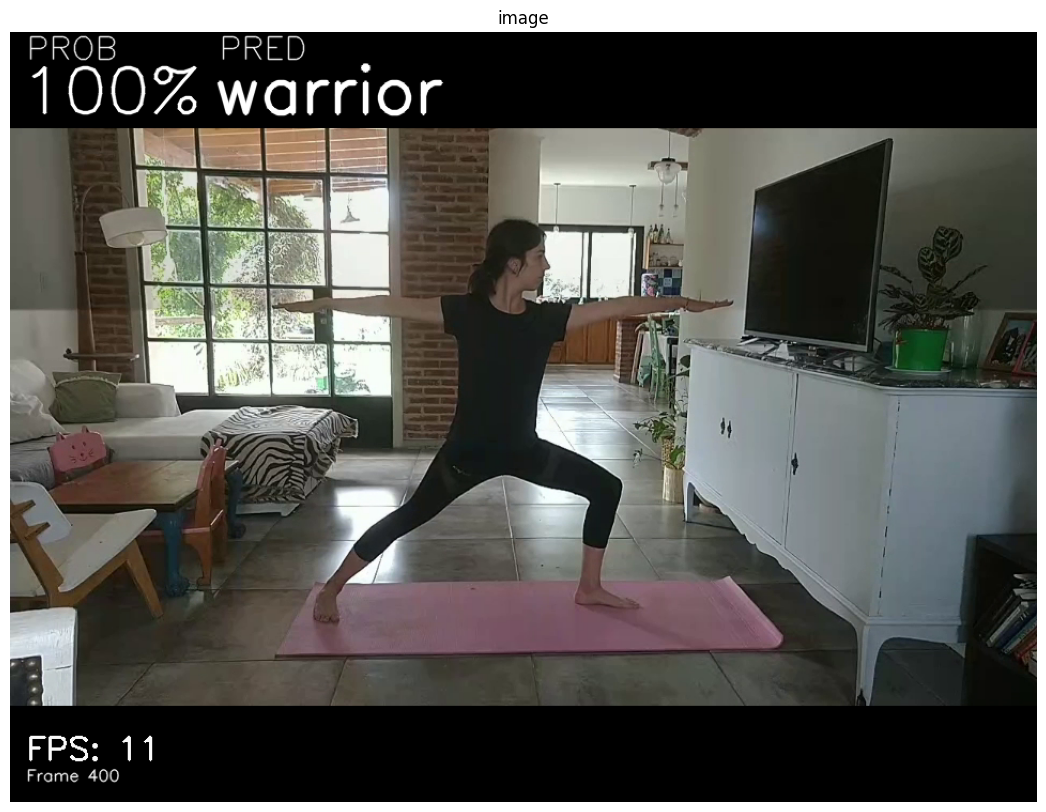

In [44]:
cap = cv2.VideoCapture('interface/pages/Data//sample_video.mp4')

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

result = cv2.VideoWriter('Video//out_video_mp.mp4',
                             cv2.VideoWriter_fourcc(*"mp4v"),
                             20,
                             (width, height), True)

start_time = time.time()
prev_frame_time = 0
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        success, frame = cap.read()

        if not success:
            pass
        if frame is None:
            break

        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = pose.process(image)

        # Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)        
        
        # Predicción del Frame
        poses = results.pose_landmarks.landmark
        row = list(np.array(
            [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                for landmark in poses]).flatten())
        X = pd.DataFrame([row], columns=landmarks)
        pred = model.predict(X)[0]
        probabilities = model.predict_proba(X)[0]

        # Mido FPS
        current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        new_frame_time = time.time()
        fps = int(1/(new_frame_time-prev_frame_time))
        prev_frame_time = new_frame_time

        # Generar imagen final con agregado de la imformación

        cv2.putText(image, 'PRED', (195, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                    1, cv2.LINE_AA)
        cv2.putText(image, 'PROB', (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                    1, cv2.LINE_AA)
        cv2.putText(image, str(pred), (190, 75), cv2.FONT_HERSHEY_SIMPLEX, 2,
                    (255, 255, 255), 3, cv2.LINE_AA)
        cv2.putText(image, f'{probabilities[np.argmax(probabilities)]:.0%}',(10, 75), cv2.FONT_HERSHEY_SIMPLEX, 2,
                    (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(image, f'Frame {current_frame}', (15, height-20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image, f'FPS: {str(fps)}', (15, height-40), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    (250, 250, 250),2)

        # Guardar el video generado
        result.write(image)

        # Definir la imagen para imprimir
        print_frame = 400
        if current_frame == print_frame:
            print_image = image
        elif current_frame < print_frame:
            print_image = image

        cv2.imshow('Video', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
result.release()
cv2.destroyAllWindows()

plt.figure(figsize=[20,10])
plt.title('image'); plt.axis('off');plt.imshow(print_image[:,:,::-1]);plt.show()

# Interfaz

## Interface

Código para la estimación  por video con los indicadores en pantalla para la corrección de postura.

Code for video estimation with on-screen indicators for posture correction.

In [11]:
# Definition of necessary functions

def inFrame(lst):
    '''
    Check if specific landmarks in a list of facial landmarks are visible.

    This function checks the visibility confidence of specific body landmarks (landmark indices
    15, 16, 27, and 28) and returns True if at least one of the landmarks on each side of the face
    is visible with a confidence greater than 0.6.

    Parameters:
        lst (list): A list containing facial landmarks, where each landmark is represented as an
                    object with attributes like 'visibility'.

    Returns:
        bool: True if at least one landmark on each side of the face is visible with confidence
              greater than 0.6, False otherwise.
    '''
    if ((lst[28].visibility > 0.6 or lst[27].visibility > 0.6)
            and (lst[15].visibility > 0.6 or lst[16].visibility > 0.6)):
        return True
    return False

def calculate_angle_coord(p_cood_list):
    """
    Calculate the angle formed by three coordinates in a 2D plane.

    Parameters:
        p_cood_list (list): A list containing three 2D coordinate points as numpy arrays.

    Returns:
        float: The angle in degrees between the lines connecting the first and second points
               and the second and third points. The angle is always in the range [0, 180].
    
    first_point = p_cood_list[0][*]
    mid_point = p_cood_list[1][*]
    last_point = p_cood_list[2][*]
    """
    radians = math.atan2(p_cood_list[2][1]-p_cood_list[1][1], p_cood_list[2][0]-p_cood_list[1][0]) - \
        math.atan2(p_cood_list[0][1]-p_cood_list[1][1], p_cood_list[0][0]-p_cood_list[1][0])
    angle = abs(radians*180.0/math.pi)

    if angle > 180.0:
        angle = 360-angle

    return angle

In [12]:
# variables definition

landmarks = []
for val in range(0, 33):
    landmarks += ['x{}'.format(val), 
                  'y{}'.format(val),
                  'z{}'.format(val), 
                  'v{}'.format(val)]


# Define the angles to messure
# The angles were obtained with the data analysis of each posture
dic = {'downdog': {(12, 24, 26): 56, 
                    (24, 26, 28): 174, 
                    (24, 12, 14): 169,
                    (12, 14, 16): 165, 
                    (11, 23, 25): 57, 
                    (23, 25, 27): 174,
                    (23, 11, 13): 169, 
                    (11, 13, 15): 167},
        'warrior': {(16, 14, 12): 180, 
                    (11, 13, 15): 180, 
                    (14, 12, 24): 90, 
                    (13, 11, 23): 90,
                    (12, 24, 26): 140, 
                    (11, 23, 25): 120, 
                    (24, 26, 28): 170, 
                    (23, 25, 27): 120},
        'warrior_inv': {(16, 14, 12): 180, 
                        (11, 13, 15): 180, 
                        (14, 12, 24): 90, 
                        (13, 11, 23): 90,
                        (12, 24, 26): 120, 
                        (11, 23, 25): 140, 
                        (24, 26, 28): 120, 
                        (23, 25, 27): 170},
        'goddess': {(12, 24, 26): 120, 
                    (11, 23, 25): 120, 
                    (24, 26, 28): 120, 
                    (23, 25, 27): 120},
        'tree': {(12, 24, 26): 170, 
                (11, 23, 25): 120, 
                (24, 26, 28): 170, 
                (23, 25, 27): 60},
        'tree_inv': {(12, 24, 26): 120, 
                    (11, 23, 25): 170, 
                    (24, 26, 28): 60, 
                    (23, 25, 27): 170}
        }

# Images to display on screen
dic_images = {'downdog': 'interface/pages/Data/images_display/video/downdog.png',
                'warrior': 'interface/pages/Data/images_display/video/warrior.png',
                'warrior_inv': 'interface/pages/Data/images_display/video/warrior_inv.png',
                'goddess': 'interface/pages/Data/images_display/video/goddess.png',
                'tree': 'interface/pages/Data/images_display/video/Tree.png',
                'tree_inv': 'interface/pages/Data/images_display/video/tree_inv.png'
                }

mp_drawing = mp.solutions.drawing_utils  # Drawing helpers

### Principal
### Main

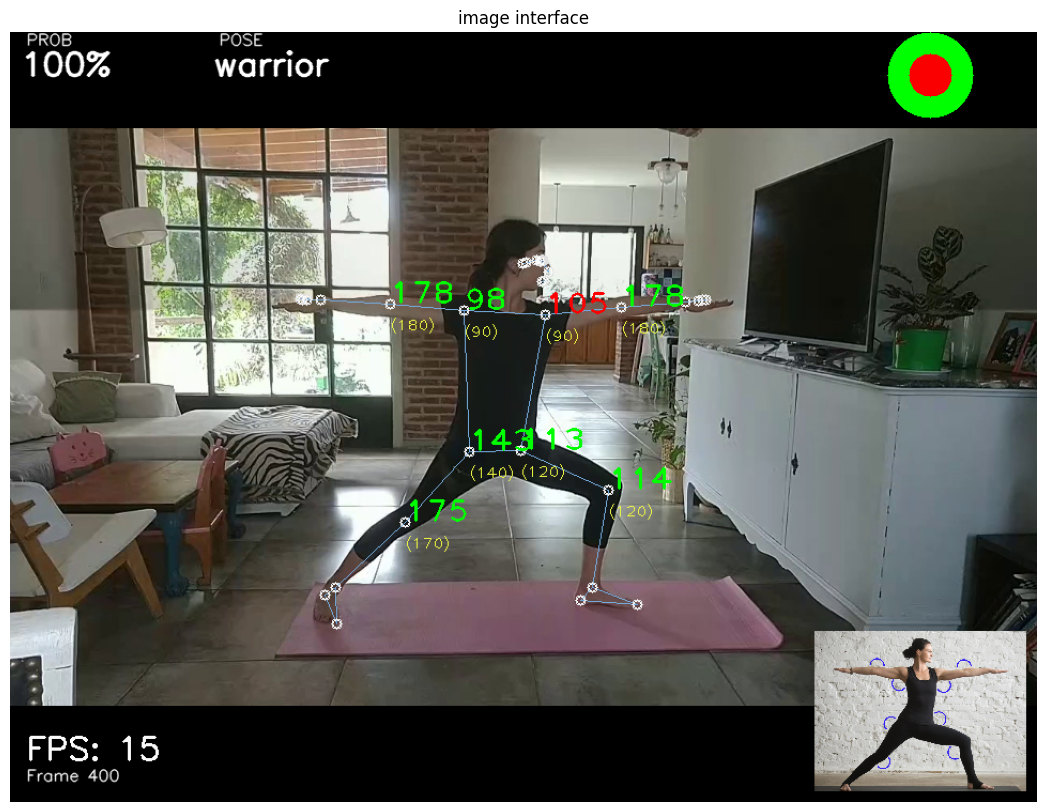

In [15]:
cap = cv2.VideoCapture('interface/pages/Data//sample_video.mp4')

frame_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


result = cv2.VideoWriter('Video//out_video_interface.mp4',
                             cv2.VideoWriter_fourcc(*"mp4v"),
                             20,
                             (frame_width, frame_height), True)

# start variables
body_language = 0
body_language_time = 0
pose_time = 0
report = []
report_time = []
prev_frame_time = 0
new_frame_time = 0

start_time = time.time()

with mp_pose.Pose(model_complexity=1, 
                    smooth_landmarks = True, 
                    min_detection_confidence=0.5, 
                    min_tracking_confidence=0.5) as pose:

    while cap.isOpened():
        success, frame = cap.read()

        if not success:
            break
        if frame is None:
            break

        # Mido FPS
        current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        new_frame_time = time.time()
        fps = 1/(new_frame_time-prev_frame_time)
        prev_frame_time = new_frame_time    
        fps = int(fps)

        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = pose.process(image)

        # Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Export coordinates
        try:
            circle_coord = ((frame_width-100), 40)

            if results.pose_landmarks and inFrame(results.pose_landmarks.landmark):

                # Draw the landmarks connections
                mp_drawing.draw_landmarks(image, results.pose_landmarks,
                                            mp_pose.POSE_CONNECTIONS,
                                            mp_drawing.DrawingSpec(color=(255, 255, 255),
                                                                    thickness=1,
                                                                    circle_radius=4),
                                            mp_drawing.DrawingSpec(color=(219, 170, 117),
                                                                    thickness=1,
                                                                    circle_radius=2)
                                            )

                # Extract Pose landmarks
                poses = results.pose_landmarks.landmark
                row = list(np.array(
                    [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                        for landmark in poses]).flatten())

                # Make Detections every 3 seconds
                time_laps = 3
                current_time = int(time.time()-start_time)
                if (body_language == 0) or (current_time % time_laps == 0):
                    X = pd.DataFrame([row], columns=landmarks)
                    body_language_class = model.predict(X)[0]
                    body_language_prob = model.predict_proba(X)[0]


                if body_language_prob[np.argmax(body_language_prob)] < 0.50:
                    body_language = 0

                # Draw the status box
                cv2.rectangle(image,
                                (0, 0),
                                (600, 60),
                                (0, 0, 0),
                                -1)

                # Display pose detected
                cv2.putText(image,
                            'POSE',
                            (195, 12),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.5,
                            (250, 250, 250),
                            1,
                            cv2.LINE_AA)

                # Check if the pose detection probability is greater than 80%
                if body_language_prob[np.argmax(body_language_prob)] >= 0.80:
                    
                    body_language = body_language_class

                    cv2.putText(image,
                                body_language_class.split(' ')[0],
                                (190, 40),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1,
                                (255, 255, 255),
                                2,
                                cv2.LINE_AA)
                    cv2.circle(image, 
                                circle_coord, 
                                40, 
                                (0, 255, 0), 
                                -1)
                else:
                    cv2.circle(image,
                                circle_coord,
                                40,
                                (0, 0, 255),
                                -1)

                # Display Probability
                cv2.putText(image,
                            'PROB',
                            (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.5,
                            (250, 250, 250),
                            1,
                            cv2.LINE_AA)
                cv2.putText(image,
                            f'{body_language_prob[np.argmax(body_language_prob)]:.0%}',
                            (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1,
                            (255, 255, 255),
                            2,
                            cv2.LINE_AA)

                if body_language:
                    # The poses 'warrior' and 'tree' are not symmetrical. The next lines check  
                    # the angle in P26 to check whether the pose detected is rigth or left
                    # and select the angles to measure in correspondence.
                    dato_pose = body_language_class
                    if body_language_class in ['warrior', 'tree']:
                        angle_1 = 0
                        try:
                            angle_1 = int(calculate_angle_coord([(
                                results.pose_landmarks.landmark[24].x,
                                results.pose_landmarks.landmark[24].y),
                                (
                                results.pose_landmarks.landmark[26].x,
                                results.pose_landmarks.landmark[26].y),
                                (
                                results.pose_landmarks.landmark[28].x,
                                results.pose_landmarks.landmark[28].y)]))

                        except:
                            pass
                        if angle_1 < 150:
                            class_inv = body_language_class + '_inv'
                            p_dic = dic.get(class_inv)
                            dato_pose = class_inv
                        else:
                            p_dic = dic.get(body_language_class)

                    else:
                        p_dic = dic.get(body_language_class)
                    
                    
                    q_ang = 0 # inicilice the counting of the angles measured
                    q_ang_ok = 0 # inicilice the counting of the angles measured ok

                    # Extract the angles points to measure from angle dict.
                    for i in range(len(p_dic)):
                        p_cood_list = []
                        midle_point = list(p_dic.keys())[i][1]
                        for p in list(p_dic.keys())[i]:
                            if results.pose_landmarks.landmark[p].visibility > 0.5:
                                
                                p_corrd = (
                                    results.pose_landmarks.landmark[p].x,
                                    results.pose_landmarks.landmark[p].y)
                                p_cood_list.append(p_corrd)
                            else:
                                break

                        try:
                            # Meassure the angles
                            angle = int(calculate_angle_coord(p_cood_list))
                            angle_ok = int(list(p_dic.values())[i])
                            q_ang += 1

                            # Print the angles into the image. Green if it is between the 
                            # tolerance and red if it is not.
                            tolerance = 15
                            if angle in range(angle_ok-tolerance, angle_ok+tolerance):
                                q_ang_ok += 1
                                text_color = (0, 255, 0)
                            else:
                                text_color = (0, 0, 255)

                            cv2.putText(image,
                                        str(angle),
                                        (int((results.pose_landmarks.landmark[midle_point].x) \
                                                *image.shape[1]),
                                            int((results.pose_landmarks.landmark[midle_point].y) \
                                                *image.shape[0])),
                                        cv2.FONT_HERSHEY_PLAIN,
                                        2,
                                        text_color,
                                        2)
                            cv2.putText(image,
                                        f'({angle_ok})',
                                        (int((results.pose_landmarks.landmark[midle_point].x) \
                                                *image.shape[1]),
                                            int((results.pose_landmarks.landmark[midle_point].y) \
                                                *image.shape[0])+25),
                                        cv2.FONT_HERSHEY_PLAIN,
                                        1,
                                        (66, 245, 236),
                                        1)

                        except:
                            pass

                    # Insert the example picture into the image
                    img_path = dic_images.get(dato_pose)
                    img = cv2.imread(img_path)
                    h = img.shape[0]
                    w = img.shape[1]
                    image[image.shape[0]-(h+10):image.shape[0]-10,
                            image.shape[1]-(w+10):image.shape[1]-10] = img
                    
                    # if any angle is out of range a red led turns on
                    if q_ang_ok != q_ang:
                        cv2.circle(image,
                            circle_coord,
                            20,
                            (0, 0, 250),
                            -1)

            # Print if the body is not fully visible                    
            else:
                cv2.putText(image,
                            "Make your Full",
                            (50, 35),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1,
                            (66, 245, 236),
                            3)
                cv2.putText(image,
                            "body visible",
                            (50, 65),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1,
                            (66, 245, 236),
                            3)
                cv2.circle(image,
                            circle_coord,
                            40,
                            (0, 0, 255),
                            -1)

        except:
            pass
        
        cv2.putText(image, f'Frame {current_frame}', (15, frame_height-20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image, f'FPS: {str(fps)}', (15, frame_height-40), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    (250, 250, 250),2)
        
        result.write(image)    

        # Definir la imagen para imprimir
        print_frame = 400
        if current_frame == print_frame:
            print_image = image
        elif current_frame < print_frame:
            print_image = image   

        cv2.imshow('Video interface', image)  

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

result.release()            
cap.release()
cv2.destroyAllWindows()

plt.figure(figsize=[20,10])
plt.title('image interface'); plt.axis('off');plt.imshow(print_image[:,:,::-1]);plt.show()